# Brain Solver Python Training Notebook

This notebook utilizes the custom `brain_solver` package for analyzing brain activity data. Our data sources include official datasets from Kaggle competitions and additional datasets for enhanced model training and evaluation.

## Data Sources

### Official:

- **HMS - Harmful Brain Activity Classification**
  - **Source:** [Kaggle Competition](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification)
  - **Description:** This competition focuses on classifying harmful brain activity. It includes a comprehensive dataset for training and testing models.

- **Brain-Spectrograms**
  - **Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/cdeotte/brain-spectrograms)
  - **Description:** The `specs.npy` file contains all the spectrograms from the HMS competition, offering a detailed view of brain activity through visual representations.

### Additional:

- **Brain-EEG-Spectrograms**
  - **Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms)
  - **Description:** The `EEG_Spectrograms` folder includes one NumPy file per EEG ID, with each array shaped as (128x256x4), representing (frequency, time, montage chain). This dataset provides a more nuanced understanding of brain activity through EEG spectrograms.

- **hms_efficientnetb0_pt_ckpts**
  - **Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/crackle/hms-efficientnetb0-pt-ckpts)
  - **Description:** This dataset offers pre-trained checkpoints for EfficientNetB0 models, tailored for the HMS competition. It's intended for use in fine-tuning models on the specific task of harmful brain activity classification.


In [1]:
# !pip install /kaggle/input/brain-solver/brain_solver-0.9.0-py3-none-any.whl

In [2]:
import os, sys
import gc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from brain_solver import Helpers as hp, Trainer as tr, BrainModel as br, EEGDataset
from brain_solver import Wav2Vec2 as w2v

# Suppress warnings if desired
import warnings

warnings.filterwarnings("ignore")

# Setup for CUDA device selection
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/osloup/NoodleNappers/brain/venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

# Config Class Summary

The `Config` class manages configurations for a brain activity classification project. It includes:

- **Data and Model Paths**: Centralizes paths for data (e.g., EEG, spectrograms) and model checkpoints.
- **Training Parameters**: Configures training details like epochs, batch size, and learning rate.
- **Feature Flags**: Toggles for using wavelets, spectrograms, and reading options.

Designed for easy adjustments to facilitate model development and experimentation.


In [3]:
from brain_solver import Config
full_path = "/home/osloup/NoodleNappers/brain/data/"
config = Config(full_path,  full_path + "out/", USE_EEG_SPECTROGRAMS=True, USE_KAGGLE_SPECTROGRAMS=True, should_read_brain_spectograms=False, should_read_eeg_spectrogram_files=False)


# full_path = "/kaggle/input/"
# config = Config(full_path, "/kaggle/working/", USE_EEG_SPECTROGRAMS=True, USE_KAGGLE_SPECTROGRAMS=True, should_read_brain_spectograms=False, should_read_eeg_spectrogram_files=False)

import sys
sys.path.append(full_path + 'kaggle-kl-div')
from kaggle_kl_div import score


In [4]:
# Create Output folder if does not exist
if not os.path.exists(config.output_path):
    os.makedirs(config.output_path)

# Initialize random environment
pl.seed_everything(config.seed, workers=True)

Seed set to 2024


2024

In [5]:
train_df: pd.DataFrame = hp.load_csv(config.data_train_csv)

if train_df is None:
    print("Failed to load the CSV file.")
    exit()
else:
    EEG_IDS = train_df.eeg_id.unique()
    TARGETS = train_df.columns[-6:]
    TARS = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
    TARS_INV = {x: y for y, x in TARS.items()}
    print("Train shape:", train_df.shape)

Train shape: (106800, 15)


In [6]:
train_data_preprocessed = hp.preprocess_eeg_data(train_df, TARGETS)

Train non-overlap eeg_id shape: (17089, 12)


In [7]:
train_data_preprocessed.head()

,eeg_id,spec_id,min_offset,max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [8]:
train_data_preprocessed.head()

,eeg_id,spec_id,min_offset,max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [9]:
spectrograms = hp.read_spectrograms(
    config.data_spectograms,
    config.path_to_brain_spectrograms_npy,
    config.should_read_brain_spectograms,
)

#data_eeg_spectograms = hp.read_eeg_spectrograms(
#    train_data_preprocessed,
#    config.path_to_eeg_spectrograms_folder,
#    config.path_to_eeg_spectrograms_npy,
#    config.should_read_eeg_spectrogram_files,
#)

data_eeg_spectograms = [] # So everything stops complaining.

# print(spectrograms)
print(w2v.wav2vec2(spectrograms))

tokenizer_config.json: 100%|██████████| 163/163 [00:00<00:00, 781kB/s]
config.json: 100%|██████████| 1.60k/1.60k [00:00<00:00, 15.6MB/s]
vocab.json: 100%|██████████| 291/291 [00:00<00:00, 1.84MB/s]
special_tokens_map.json: 100%|██████████| 85.0/85.0 [00:00<00:00, 770kB/s]
model.safetensors: 100%|██████████| 378M/378M [00:15<00:00, 24.2MB/s] 
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

In [ ]:
print(
    f"Length of spectrograms: {spectrograms.__len__()}, Length of all EEGs: {data_eeg_spectograms.__len__()}"
)

Length of spectrograms: 11138, Length of all EEGs: 17089


In [ ]:
print(
    f"Length of spectrograms: {spectrograms.__len__()}, Length of all EEGs: {data_eeg_spectograms.__len__()}"
)

Length of spectrograms: 11138, Length of all EEGs: 17089


In [ ]:
dataset = EEGDataset(
    train_data_preprocessed, spectrograms, data_eeg_spectograms, TARGETS
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

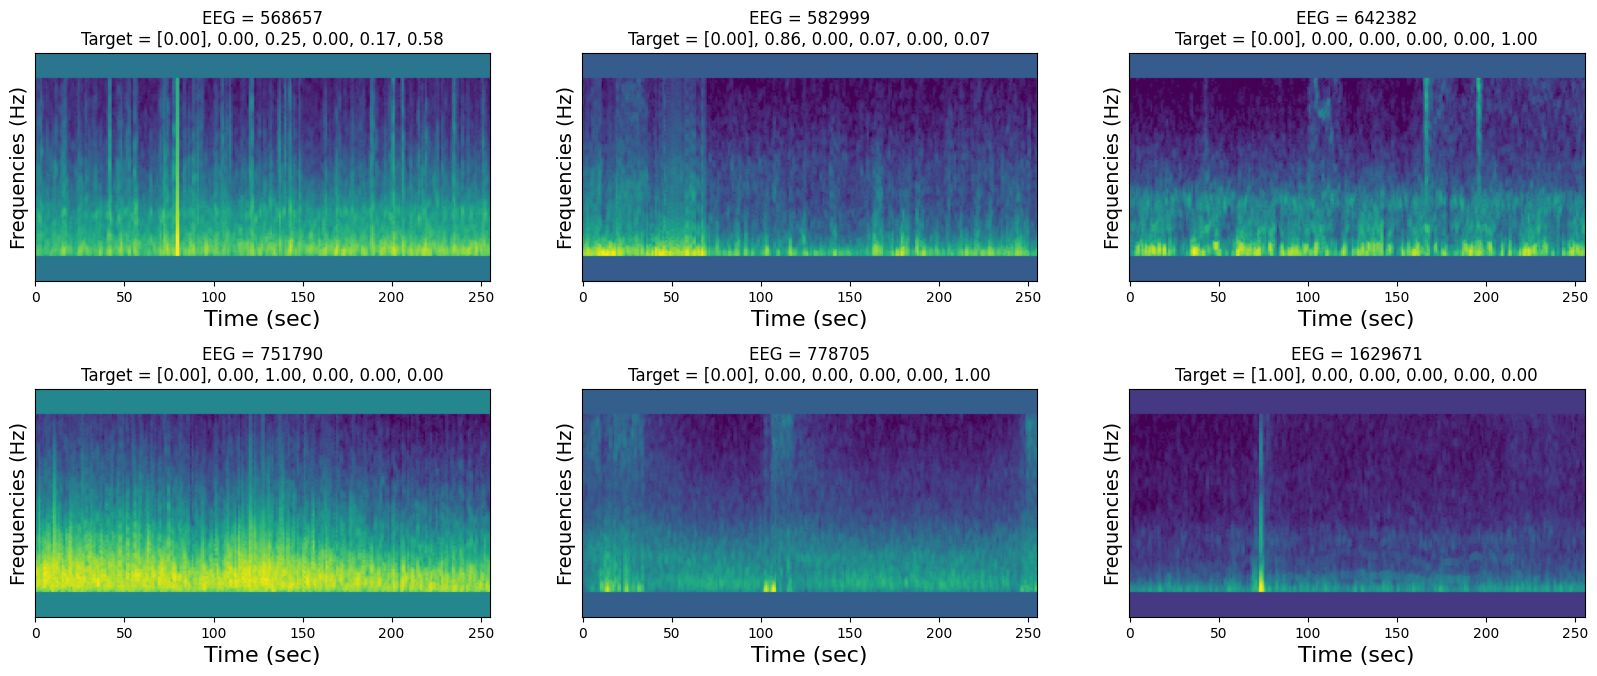

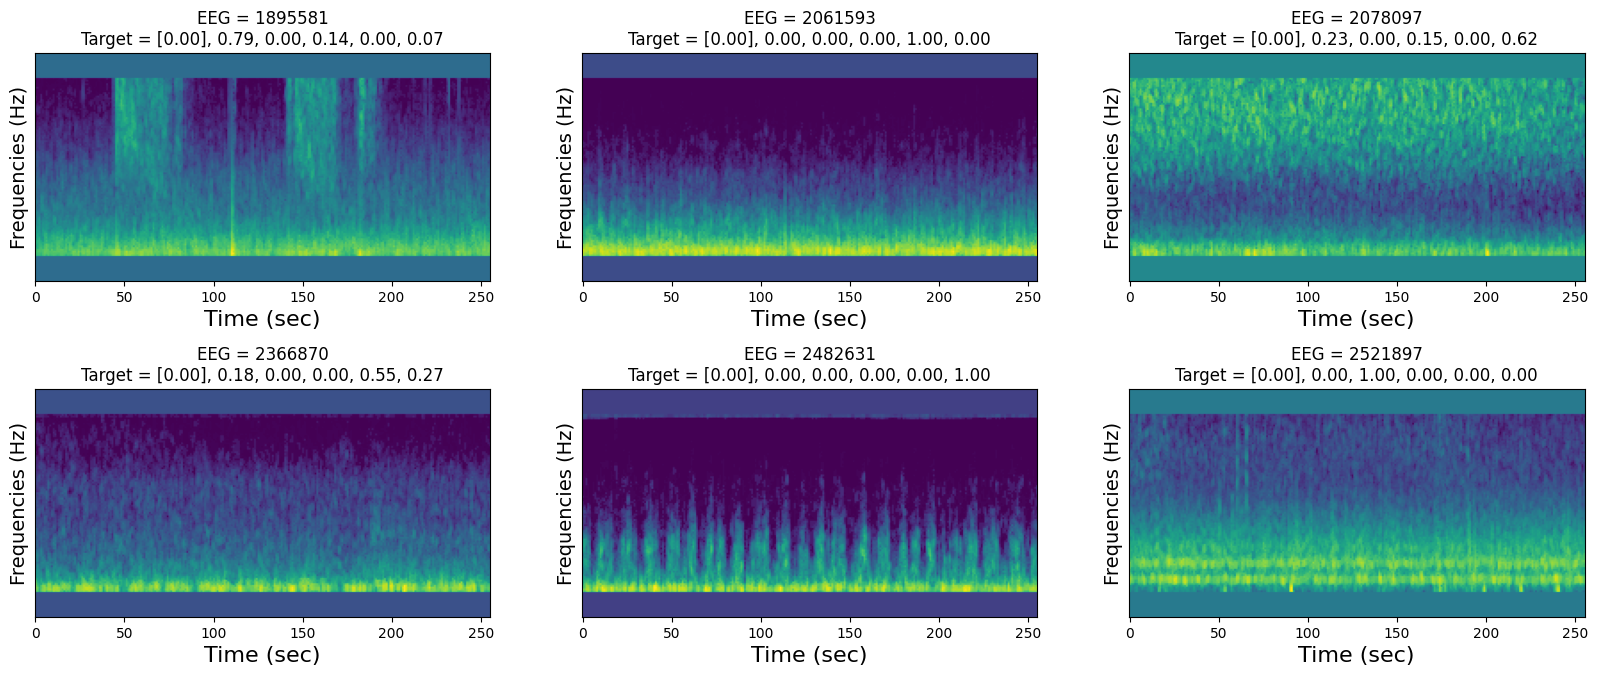

In [ ]:
hp.plot_spectrograms(
    dataloader, train_data_preprocessed, ROWS=2, COLS=3, BATCHES=2
)

In [ ]:
del dataset, dataloader
gc.collect()

31249

In [ ]:
model = tr(
    config.trained_weight_file,
    config.USE_KAGGLE_SPECTROGRAMS,
    config.USE_EEG_SPECTROGRAMS,
)

In [ ]:
all_oof, all_true, valid_loaders = br.cross_validate_eeg(
    config,
    train_data_preprocessed=train_data_preprocessed,
    spectrograms=spectrograms,
    data_eeg_spectograms=data_eeg_spectograms,
    TARGETS=TARGETS,
    n_splits=5,
    batch_size_train=32,
    batch_size_valid=64,
    max_epochs=4,
    num_workers=3,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 1
### Train size: 13671, Valid size: 3418
#########################


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 2
### Train size: 13671, Valid size: 3418
#########################


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 3
### Train size: 13671, Valid size: 3418
#########################


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 4
### Train size: 13671, Valid size: 3418
#########################
#########################
### Fold 5
### Train size: 13672, Valid size: 3417
#########################


In [ ]:
all_oof, all_true = br.validate_model_across_folds(config, device, all_oof, all_true, valid_loaders)

#########################
### Validating Fold 1


#########################
### Validating Fold 2


In [ ]:
oof = pd.DataFrame(all_oof.copy())
oof["id"] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true["id"] = np.arange(len(true))

# Calculate the score
cv = score(solution=true, submission=oof, row_id_column_name="id")
print("CV Score KL-Div for EfficientNetB2 =", cv)


CV Score KL-Div for EfficientNetB2 = 0.64318060973997


In [ ]:
del data_eeg_spectograms, spectrograms
gc.collect()

0